<a href="https://colab.research.google.com/github/urmzd/md-nlp/blob/main/src/one-hot-encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyppeteer
!pip install ipython ipykernel --upgrade

In [2]:
!apt-get update 
!apt-get install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!dpkg -L chromium-chromedriver

Hit:1 https://dl.google.com/linux/chrome/deb stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:

In [3]:
import random
from numpy import random as nprd
import tensorflow as tf
tf.random.set_seed(42)
random.seed(42)
nprd.seed(42)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
import asyncio
import re
import csv
import pyppeteer as ptr
import pandas as pd
import nltk
from typing import Optional, TypeVar
from typing import Callable
from glob import glob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [7]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
resource_path = "/content/drive/MyDrive/resources2/"

data_path = resource_path + "data/"
data_source_path = data_path + "sources"
data_target_path = data_path + "targets"

In [10]:
from typing import List, Tuple
PosTag = Tuple[str, str]
PosTagList = List[PosTag]
StemWord = str
StemWordList = List[StemWord]

In [11]:
global_config = {
    "word_limit": 56,
    "n_samples": 750,
    "test_size": 0.2
}

In [12]:
def get_name_and_extension(file_path: str) -> Tuple[str, str]:
    regex = re.compile(r"(.*)/(.*)\.(.*)")
    return regex.match(file_path).group(2,3)

In [13]:
async def download_html(browser: ptr.browser.Browser, page: ptr.page.Page, url: str, selector: str) -> Optional[str]:
    await page.goto(url, waitUntil="load", timeout=0)
    print(f"Going to collect from {url} using selector {selector}")
    content = await page.querySelector(selector)

    html = ''
    if content:
        html = await page.evaluate('(element) => element.textContent', content)
        
    return html

def write_to_resource_target(target_path: str, file_name: str, content: StemWordList, extension="txt") -> None:
    with open(f"{target_path}/{file_name}.{extension}", "a") as file:
        file.write("\n".join(content))


async def get_training_data_from_folder(source_path: str, target_path: str, force=False) -> None:
    browser = await ptr.launch(
        executablePath="/usr/bin/chromium-browser", 
        args= ['--no-sandbox']
    )
    page = await browser.newPage()
    
    glob_pattern = "/**/*"
    source_files = glob(source_path + glob_pattern, recursive=True)
    target_files = glob(target_path + glob_pattern, recursive=True)
    target_file_names = [get_name_and_extension(file_path)[0] for file_path in target_files]
    
    for file_path in source_files:
        [file_name, file_extension] = get_name_and_extension(file_path)
        
        if not file_name in target_file_names or force:
            result = await get_training_data(browser, page, file_path)
            write_to_resource_target(target_path, file_name, result)        
                
    await browser.close()

async def get_training_data(browser: ptr.browser.Browser, page: ptr.page.Page, file_path: str) -> StemWordList:
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    words = []
    if isinstance(df, pd.DataFrame):
        for _, row in df.iterrows():
            result = await download_html(browser, page, row["link"], row["selector"])
            words.extend(clean_up_words(tokenize(result)))
    
    return words

In [14]:
T = TypeVar("T")
R = TypeVar("R")

TestValueStrCallable = Callable[[T], str]
TestValueBoolCallable = Callable[[T], bool]
ValueTestFnCallable = Callable[[T], TestValueStrCallable]
FilterCallable = Callable[[ValueTestFnCallable], bool]
MapCallable = Callable[[ValueTestFnCallable], str]

def tokenize(data: str) -> PosTagList:
    tokenized_words = nltk.word_tokenize(data)
    mutated_words = nltk.pos_tag(tokenized_words)
    return mutated_words

def filter_words(x: T, test_value: TestValueStrCallable, *fns: FilterCallable) -> bool:
    if fns:
        if fns[0](x, test_value):
            return filter_words(x, test_value, *fns[1:])
        else:
            return False
    
    return True
    
def filter_by_punctuation(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
    return x[0] != x[1]

def filter_by_stop_word(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
    return test_value(x) not in stopwords.words("english")

def regex_filter(regex: str):
    def filter_by_regex(x: T, test_value: TestValueStrCallable = lambda t: t[0]):
        rgx = re.compile(regex)
        return rgx.match(test_value(x))
    return filter_by_regex

filter_by_alphabet = regex_filter(r"^([a-zA-Z]|')+$")
filter_by_apostrophe = regex_filter(r"^[^']*$")

def map_by_stem_words(x: PosTag, test_value: TestValueStrCallable = lambda t: t[0], ps=PorterStemmer()) -> StemWord:
    return ps.stem(test_value(x)).lower()

def map_words(x: T, test_value: TestValueStrCallable, *fns: MapCallable) -> StemWord:
    if fns:
        return map_words(fns[0](test_value(x)), test_value, *fns[1:])

    return x
            
def clean_up_words(words: PosTagList) -> StemWordList:
    filtered_words = list(set(
        filter(
        lambda x: filter_words(x, lambda x: x[0], filter_by_punctuation, filter_by_stop_word, filter_by_alphabet),
        words
        )
    ))

    stem_words = list(set(map(lambda x: map_words(x, lambda x: x, map_by_stem_words), filtered_words)))
    
    return list(set(
        filter(
            lambda x: filter_words(x, lambda x: x, filter_by_apostrophe), 
            stem_words)
    ))

In [15]:
!curl -sSL https://dl.google.com/linux/linux_signing_key.pub | apt-key add -
!echo "deb [arch=amd64] https://dl.google.com/linux/chrome/deb/ stable main" > /etc/apt/sources.list.d/google-chrome.list
!apt update -y && apt install -y google-chrome-stable

OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://dl.google.com/linux/chrome/deb stable InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
H

In [16]:
await get_training_data_from_folder(data_source_path, data_target_path)

In [17]:
from typing import Dict

def get_cleaned_data_from_file(input_file_path: str) -> Optional[List[str]]:
    with open(input_file_path, "r") as file:
        return [word.strip("\n") for word in list(file.readlines())]

def get_cleaned_data_from_folder(input_path: str) -> Dict[str, PosTagList]:
    glob_pattern = "/**/*"
    input_files = glob(input_path + glob_pattern, recursive=True)
    
    data = dict()
    for file_path in input_files:
        [file_name, file_extension] = get_name_and_extension(file_path)
        classification_data = get_cleaned_data_from_file(file_path)
        data[file_name] = classification_data
        
    return data

In [18]:
from nltk.probability import WittenBellProbDist, FreqDist,LaplaceProbDist
import numpy as np

def unpack_dict_list(dict_list: Dict[str, StemWordList]):
    return [v for k in dict_list for v in dict_list[k]]

def generate_sample(population: StemWordList, label: str, n_unique_words: int, word_limit = global_config["word_limit"]):
    freq_dist = FreqDist(population)
    prob_dist = WittenBellProbDist(freq_dist, n_unique_words)
    
    samples = [prob_dist.generate() for _ in range(word_limit)]

    return np.array(list([*samples, label])).reshape(-1, 1)

def generate_samples(data: Dict[str, StemWordList], n_samples = global_config["n_samples"]):
    n_unique_words = len(set(unpack_dict_list(data)))
    
    return np.array([np.array([generate_sample(data[k], k, n_unique_words) for _ in range(n_samples)]) for k in data])

In [19]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from typing import Union

def get_one_hot_encoder(population: Dict[str, StemWordList]):
    population_array = np.array(list(set(unpack_dict_list(population)))).reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(population_array)
    return encoder

def get_label_encoder(labels: np.ndarray):
    encoder = LabelBinarizer()
    encoder.fit(labels)
    return encoder

def transform_data_by_encoder(data: np.ndarray, encoder: Union[OneHotEncoder, LabelBinarizer]):
    encoded_data = encoder.transform(data)
    
    if not isinstance(encoded_data, np.ndarray):
        encoded_data = encoded_data.toarray()
        
    return encoded_data

def split_into_x_y(samples: np.ndarray):
    x = samples[:,:,:-1]
    y = samples[:,:,-1]
    y = y.reshape(y.shape[0]*y.shape[1], 1)
    return (x,y)
    
def transform_x_y(x: np.ndarray, y: np.ndarray, in_coder: OneHotEncoder, out_coder: LabelBinarizer):   
    encoded_x = np.stack([
        transform_data_by_encoder(x[lbl_idx, smpl_idx], in_coder)
        for lbl_idx in range(x.shape[0])
        for smpl_idx in range(x.shape[1])
    ], axis=0)
            
    encoded_y = transform_data_by_encoder(y, out_coder)
    
    return (encoded_x, encoded_y)

In [20]:
import pickle

model_path = resource_path + "models/"
input_encoder_file_name = "input_encoder.pickle"
output_encoder_file_name = "output_encoder.pickle"

def get_x_y(path = data_target_path, n_samples=2000):
    result = get_cleaned_data_from_folder(data_target_path)
    samples = generate_samples(result, n_samples)
    x,y = split_into_x_y(samples)

    encoder_paths = glob(model_path + "*.pickle", recursive=True)
    encoder_file_names = [get_name_and_extension(file_path)[0] for file_path in encoder_paths]

    if input_encoder_file_name in encoder_file_names:
      input_encoder = pickle.load(open(encoder_paths[encoder_file_names.index(input_encoder_file_name)], "rb"))
    else:
      input_encoder = get_one_hot_encoder(result)

    if output_encoder_file_name in encoder_file_names:
      output_encoder = pickle.load(open(encoder_paths[encoder_file_names.index(output_encoder_file_name)], "rb"))
    else:
      output_encoder = get_label_encoder(y)

    pickle.dump(input_encoder, open(model_path + input_encoder_file_name, "wb"))
    pickle.dump(output_encoder, open(model_path + output_encoder_file_name, "wb"))

    return transform_x_y(x, y, input_encoder, output_encoder)

In [21]:
def get_data(n_samples=global_config["n_samples"], test_size=global_config["test_size"], random_state=42):
    x, y = get_x_y(n_samples=n_samples)
    x=x.reshape((*x.shape, 1))
    return train_test_split(x, y, test_size=test_size, random_state=random_state)

x_train, x_test, y_train, y_test = get_data()

tcmalloc: large alloc 4243685376 bytes == 0x557ea047a000 @  0x7fef72f561e7 0x7fef6974d46e 0x7fef6979dc7b 0x7fef6979dd18 0x7fef69845010 0x7fef6984573c 0x7fef6984585d 0x557d993f2749 0x7fef6978aef7 0x557d993f0437 0x557d993f0240 0x557d99463973 0x557d9945e9ee 0x557d993f1bda 0x557d99460737 0x557d9945eced 0x557d99330e2b 0x7fef6978aef7 0x557d993f0437 0x557d993f0240 0x557d99463973 0x557d9945e9ee 0x557d993f1bda 0x557d99460737 0x557d9945eced 0x557d993f1bda 0x557d9945f915 0x557d9945e9ee 0x557d993f1bda 0x557d99460737 0x557d993f1d51
tcmalloc: large alloc 3394945024 bytes == 0x557da32c2000 @  0x7fef72f561e7 0x7fef6974d46e 0x7fef6979dc7b 0x7fef6979dd18 0x7fef698303a9 0x7fef69832ab5 0x557d994d8409 0x557d9945fe7a 0x557d9945e9ee 0x557d993f1bda 0x557d99460737 0x557d9945eced 0x557d993f1bda 0x557d9945f915 0x557d994e2cf8 0x557d994d8cae 0x557d994c8ae5 0x557d993ff224 0x557d994300a4 0x557d993f0c52 0x557d99463c25 0x557d9945eced 0x557d993f1bda 0x557d99460737 0x557d993f1d51 0x557d9945f915 0x557d9945e9ee 0x557d9945

In [22]:
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers

history_path = model_path + "history.npy"

def save_history(history: np.ndarray):
  np.save(history_path, history, allow_pickle=True)

def load_history() -> Dict:
  if os.path.exists(history_path):
    return np.load(history_path, allow_pickle=True).item()

  return {}

def train_cnn():
    input_shape = x_train.shape[1:]

    config = {}

    config["conv_layer_0"] = {
        "filters": 3,
        "kernel_size": (3, 3),
        "strides": 1,
        "activation": "relu",
    }

    config["pool_layer_0"] = {
        "pool_size": (2,2),
        "padding": "same"
    }

    config["conv_layer_1"] = {
        "filters": 3,
        "kernel_size": (3, 3),
        "strides": 2,
        "activation": "relu"
    }

    config["pool_layer_1"] = {
        "pool_size": (2,2),
        "padding": "same",
    }

    config["dense_layer_5"] = {
        "units": 64,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(0, 17e-1)
    }

    config["dropout_layer_3"] = {
        "rate": 0.5,
    }

    config["dense_layer_6"] = {
        "units": 64,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(0, 18e-1)
    }

    config["dropout_layer_9"] = {
        "rate": 0.5,
    }

    config["dense_layer_7"] = {
        "units": 64,
        "activation": "relu",
        "kernel_regularizer": regularizers.l1_l2(0, 12e-1),
        "bias_regularizer": regularizers.l1_l2(0, 1e-11)
    }

    config["dropout_layer_0"] = {
        "rate": 0.5,
    }

    config["dense_layer_8"]= {
        "units": 128,
        "activation": "relu",
        "kernel_regularizer": regularizers.l1_l2(0, 4e-7),
        "bias_regularizer": regularizers.l1_l2(0, 9e-1)
    }

    config["dropout_layer_1"]= {
        "rate": 0.5
    }

    config["flatten_layer_0"] = {
    }

    config["dense_layer_final"] = {
        "units": (y_train.shape[-1]),
        "activation": "softmax"
    }

    config["model_compile"] = {
        "optimizer": tf.keras.optimizers.Adam(0.001),
        "loss": keras.losses.binary_crossentropy,
        "metrics": ["accuracy", keras.metrics.Recall()]
    }

    config["model_fit"] = {
         "x": x_train,
         "y": y_train,
         "batch_size": 2,
         "epochs": 16,
         "validation_split" : global_config["test_size"]
    }

    encoder_input = keras.Input(shape=input_shape)
    prev_layer = encoder_input
    encoder_output=None

    layer_types = {
        "dense": layers.Dense,
        "flatten": layers.Flatten,
        "dropout": layers.Dropout,
        "conv": layers.Conv2D,
        "pool": layers.MaxPool2D,
    }
    
    for k,v in config.items():
      type_of_layer, *_ = k.split("_")
      if type_of_layer != "model":
        encoder_output = layer_types[type_of_layer](**v)(prev_layer)
        prev_layer = encoder_output
    
    config["model"] = {
        "inputs": encoder_input,
        "outputs": encoder_output,
        "name": "encoder"
    }

    model = keras.Model(**config["model"])
    model.compile(**config["model_compile"])

    print(model.summary())
    
    history = model.fit(**config["model_fit"])
    save_history(history.history)

    test_scores = model.evaluate(x_test, y_test, verbose=2)

    return model    

In [28]:
model = train_cnn()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56, 4210, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 4208, 3)       30        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 2104, 3)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 1051, 3)       84        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 526, 3)        0         
 2D)                                                             
                                                                 
 dense_5 (Dense)             (None, 7, 526, 64)        256 

In [24]:
def clean_up_user_input(sentence: str, word_limit=56):
  tokenized_words = tokenize(sentence)
  
  word = clean_up_words(tokenized_words)
  words_to_test = np.array(word).reshape(-1, 1)

  if not words_to_test.size:
    return np.array([])

  input_encoder = pickle.load(open(model_path + input_encoder_file_name, "rb"))

  encoded_data = transform_data_by_encoder(words_to_test, input_encoder) 
  difference = word_limit - encoded_data.shape[0]
  zero_array = np.zeros(encoded_data.shape[1])

  for _ in range(difference):
    encoded_data = np.append(encoded_data, [zero_array], axis=0)

  return encoded_data

In [29]:
import os

cnn_folder = "cnn"
cnn_path = model_path + cnn_folder

def save_cnn(override:bool=False, model=model):
  if not os.path.exists(cnn_path) or override:
    model.save(cnn_path)

save_cnn()

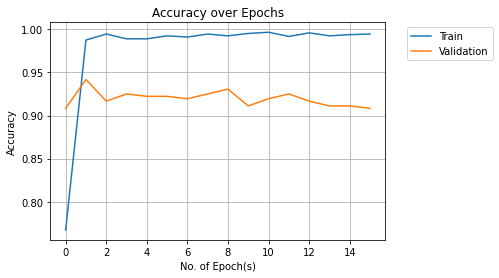

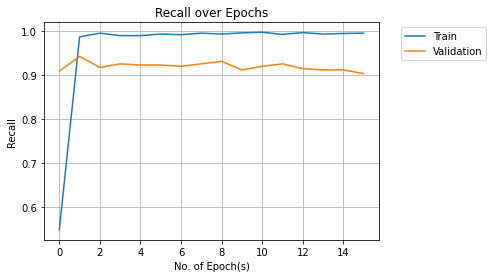

In [30]:
from keras import models
from matplotlib import pyplot as plt

graph_path = resource_path + "graphs/"

def plot_cnn(metric:str):
  history = load_history()
  regex = re.compile(fr'{metric}.*$')
  metrics = list(filter(regex.search, history.keys()))
  training_metric, val_metric = metrics
  name, *_ = training_metric.split("_")
  fig, ax = plt.subplots()
  ax.plot(history[training_metric])
  ax.plot(history[val_metric])
  ax.set_title(f'{name.title()} over Epochs')
  ax.set_ylabel(name.title())
  ax.set_xlabel('No. of Epoch(s)')
  ax.grid()
  legend = ax.legend(['Train', 'Validation'], bbox_to_anchor=(1.05, 1))

  os.makedirs(graph_path, exist_ok=True)
  fig.savefig(graph_path + metric, bbox_extra_artists=[legend], bbox_inches='tight')

  plt.show()


plot_cnn("accuracy")
plot_cnn("recall")

In [32]:
from tensorflow import keras
def predict(sentence: str):
  model_path = resource_path + "models/"
  cnn_folder = "cnn"
  cnn_path = model_path + cnn_folder
  word = clean_up_user_input(sentence)
  model = keras.models.load_model(cnn_path)

  if word.size:
    word = word.reshape(*word.shape, 1)
    words = np.array([word])
    output_encoder: LabelBinarizer = pickle.load(open(model_path + output_encoder_file_name, "rb"))
    prediction = model.predict(words)
    prediction_binary = np.zeros_like(prediction)
    prediction_binary[:,prediction.argmax(1)] = 1
    print(prediction)
    print(output_encoder.inverse_transform(prediction))
    ailment:str = output_encoder.inverse_transform(prediction)[0]
    return ailment.upper()
y_true = ["DEPRESSION","DEPRESSION","DEPRESSION","DEPRESSION","DEPRESSION",
          "MIGRAINE","MIGRAINE","MIGRAINE","MIGRAINE","MIGRAINE","TETANUS",
          "TETANUS","TETANUS","TETANUS","TETANUS"]
y_pred = []
#Depression
y_pred.append(predict("I feel suicidal. Mental health kill hurt someone else medicine need help neuropath"))
y_pred.append(predict("I'm so sad, really feeling down, been gaining weight, no sleep"))
y_pred.append(predict("No sleep, feel lonely, really upset, feel nothing"))
y_pred.append(predict("Wow life sucks right now, super depressed, want to kill myself"))
y_pred.append(predict("I'm really depressed, suicidal, want to kill or hurt myself"))

#Migraine
y_pred.append(predict("I have a headache. I feel senstivity to light. My head is hurting. It's twirling. I feel an aura."))
y_pred.append(predict("I am sensitive to light. I feel an aura around my body. Migraine"))
y_pred.append(predict("My head hurts a lot, there's an aura surrounding me."))
y_pred.append(predict("My head feels like its spinning, pain in head, pounding throbbing"))
y_pred.append(predict("My head hurts a lot, there's an aura surrounding me."))

#Tetanus
y_pred.append(predict("I have a jaw ache. It's tetanus. My muscles are stiff"))
y_pred.append(predict("I feel really stiff and like I can't move"))
y_pred.append(predict("My jaw is really sore and aching, I think I have tetanus"))
y_pred.append(predict("My muscles are so stiff, I don't have a vaccine for tetanus"))
y_pred.append(predict("It's tetanus. My muscles are stiff. I have a jaw ache."))

[[9.9963546e-01 3.6329721e-04 1.2394855e-06]]
['depression']
[[9.9999523e-01 1.2663323e-06 3.4653012e-06]]
['depression']
[[0.99498355 0.0037208  0.0012956 ]]
['depression']
[[9.9802798e-01 9.5619762e-04 1.0157512e-03]]
['depression']
[[9.9999321e-01 4.3419700e-06 2.4870262e-06]]
['depression']
[[1.1371721e-04 9.9988163e-01 4.6152418e-06]]
['migraine']
[[3.3899551e-04 9.9934715e-01 3.1380617e-04]]
['migraine']
[[0.21465904 0.7754833  0.00985758]]
['migraine']
[[0.00124718 0.9957973  0.00295565]]
['migraine']
[[0.21465904 0.7754833  0.00985758]]
['migraine']
[[9.5626747e-06 1.0785037e-04 9.9988258e-01]]
['tetanus']
[[9.9386901e-01 5.8024516e-03 3.2848274e-04]]
['depression']
[[2.3296904e-03 3.3188760e-04 9.9733835e-01]]
['tetanus']
[[6.9744229e-02 1.5927035e-04 9.3009645e-01]]
['tetanus']
[[9.5626747e-06 1.0785037e-04 9.9988258e-01]]
['tetanus']


['DEPRESSION', 'DEPRESSION', 'DEPRESSION', 'DEPRESSION', 'DEPRESSION', 'MIGRAINE', 'MIGRAINE', 'MIGRAINE', 'MIGRAINE', 'MIGRAINE', 'TETANUS', 'DEPRESSION', 'TETANUS', 'TETANUS', 'TETANUS']
['DEPRESSION', 'DEPRESSION', 'DEPRESSION', 'DEPRESSION', 'DEPRESSION', 'MIGRAINE', 'MIGRAINE', 'MIGRAINE', 'MIGRAINE', 'MIGRAINE', 'TETANUS', 'TETANUS', 'TETANUS', 'TETANUS', 'TETANUS']
[[5 0 0]
 [0 5 0]
 [1 0 4]]


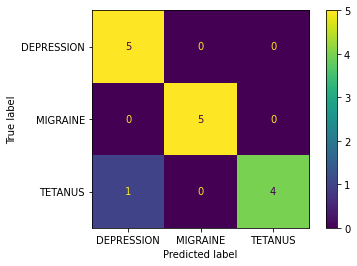

In [33]:
from sklearn import metrics


display_labels=["DEPRESSION","MIGRAINE","TETANUS"]
cm = metrics.confusion_matrix(y_true,y_pred,labels=["DEPRESSION","MIGRAINE","TETANUS"])

print(y_pred)
print(y_true)

print(cm)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot()

plt.savefig(graph_path + "confusion_matrix")